In [1]:
import pandas as pd

# Load the dataframe
df = pd.read_csv('BTC_USDT_15m.csv')

# Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a new column for the session
def get_session(hour):
    if 0 <= hour < 8:
        return 'Asia_1'
    elif 8 <= hour < 13:
        return 'London'
    elif 13 <= hour < 22:
        return 'NY'
    else:
        return 'Asia_2'

df['session'] = df['timestamp'].dt.hour.apply(get_session)

# Initialize columns for session high and low
df['session_high'] = None
df['session_low'] = None

# Group by date and session to find high and low for each session
for (date, session), group in df.groupby([df['timestamp'].dt.date, 'session']):
    session_high = group['high'].max()
    session_low = group['low'].min()
    df.loc[group.index, 'session_high'] = session_high
    df.loc[group.index, 'session_low'] = session_low

# Create columns to compare session highs and lows
df['london_exceeds_asia_high'] = False
df['london_exceeds_asia_low'] = False
df['price_moved_from_london_high'] = False
df['price_after_london_high'] = None
df['price_moved_from_london_low'] = False
df['price_after_london_low'] = None
df['percent_move_from_london_high'] = None
df['percent_move_from_london_low'] = None

df['ny_exceeds_london_high'] = False
df['ny_exceeds_london_low'] = False

df['both_london_ny_exceed_high'] = False
df['both_london_ny_exceed_low'] = False

df['percent_both_london_ny_exceed_high'] = None
df['percent_both_london_ny_exceed_low'] = None

# Iterate over each date to compare session highs and lows
for date, group in df.groupby(df['timestamp'].dt.date):
    # Extract session high and low values
    asia_high = group[group['session'] == 'Asia_1']['session_high'].max()
    asia_low = group[group['session'] == 'Asia_1']['session_low'].min()
    london_high = group[group['session'] == 'London']['session_high'].max()
    london_low = group[group['session'] == 'London']['session_low'].min()
    ny_high = group[group['session'] == 'NY']['session_high'].max()
    ny_low = group[group['session'] == 'NY']['session_low'].min()

    # Compare London session with Asia session
    london_exceeds_asia_high = pd.notna(london_high) and pd.notna(asia_high) and london_high > asia_high
    london_exceeds_asia_low = pd.notna(london_low) and pd.notna(asia_low) and london_low < asia_low

    if london_exceeds_asia_high:
        df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'london_exceeds_asia_high'] = True
        # Find the lowest price within London session after creating the session high
        london_high_time = group[(group['session'] == 'London') & (group['high'] == london_high)]['timestamp'].max()
        opposite_low = group[(group['session'] == 'London') & (group['timestamp'] > london_high_time)]['low'].min()
        if pd.notna(opposite_low):
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'price_moved_from_london_high'] = True
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'price_after_london_high'] = opposite_low
            percent_move = ((london_high - opposite_low) / london_high) * 100
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'percent_move_from_london_high'] = percent_move

    if london_exceeds_asia_low:
        df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'london_exceeds_asia_low'] = True
        # Find the highest price within London session after creating the session low
        london_low_time = group[(group['session'] == 'London') & (group['low'] == london_low)]['timestamp'].max()
        opposite_high = group[(group['session'] == 'London') & (group['timestamp'] > london_low_time)]['high'].max()
        if pd.notna(opposite_high):
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'price_moved_from_london_low'] = True
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'price_after_london_low'] = opposite_high
            percent_move = ((opposite_high - london_low) / london_low) * 100
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'London'), 'percent_move_from_london_low'] = percent_move

    # Compare NY session with London session
    ny_exceeds_london_high = pd.notna(ny_high) and pd.notna(london_high) and ny_high > london_high
    ny_exceeds_london_low = pd.notna(ny_low) and pd.notna(london_low) and ny_low < london_low

    if ny_exceeds_london_high:
        df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'NY'), 'ny_exceeds_london_high'] = True
        if london_exceeds_asia_high:
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'NY'), 'both_london_ny_exceed_high'] = True
            if pd.notna(opposite_low):
                percent_both_move = ((ny_high - opposite_low) / ny_high) * 100
                df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'NY'), 'percent_both_london_ny_exceed_high'] = percent_both_move

    if ny_exceeds_london_low:
        df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'NY'), 'ny_exceeds_london_low'] = True
        if london_exceeds_asia_low:
            df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'NY'), 'both_london_ny_exceed_low'] = True
            if pd.notna(opposite_high):
                percent_both_move = ((opposite_high - ny_low) / ny_low) * 100
                df.loc[(df['timestamp'].dt.date == date) & (df['session'] == 'NY'), 'percent_both_london_ny_exceed_low'] = percent_both_move

# Extract date from the timestamp
df['date'] = df['timestamp'].dt.date

# Aggregate the session high and low values for each date and retain only necessary columns
aggregated_df = df.groupby('date').agg(
    asian_session_high=('session_high', lambda x: x[df['session'] == 'Asia_1'].max()),
    asian_session_low=('session_low', lambda x: x[df['session'] == 'Asia_1'].min()),
    london_session_high=('session_high', lambda x: x[df['session'] == 'London'].max()),
    london_session_low=('session_low', lambda x: x[df['session'] == 'London'].min()),
    ny_session_high=('session_high', lambda x: x[df['session'] == 'NY'].max()),
    ny_session_low=('session_low', lambda x: x[df['session'] == 'NY'].min()),
    london_exceeds_asia_high=('london_exceeds_asia_high', 'max'),
    london_exceeds_asia_low=('london_exceeds_asia_low', 'max'),
    price_moved_from_london_high=('price_moved_from_london_high', 'max'),
    price_after_london_high=('price_after_london_high', 'max'),
    price_moved_from_london_low=('price_moved_from_london_low', 'max'),
    price_after_london_low=('price_after_london_low', 'max'),
    percent_move_from_london_high=('percent_move_from_london_high', 'max'),
    percent_move_from_london_low=('percent_move_from_london_low', 'max'),
    ny_exceeds_london_high=('ny_exceeds_london_high', 'max'),
    ny_exceeds_london_low=('ny_exceeds_london_low', 'max'),
    both_london_ny_exceed_high=('both_london_ny_exceed_high', 'max'),
    both_london_ny_exceed_low=('both_london_ny_exceed_low', 'max'),
    percent_both_london_ny_exceed_high=('percent_both_london_ny_exceed_high', 'max'),
    percent_both_london_ny_exceed_low=('percent_both_london_ny_exceed_low', 'max')
).reset_index()

# Save the cleaned dataframe to a new CSV file
aggregated_df.to_csv('BTC_USDT_15m_cleaned.csv', index=False)

# Display the first few rows of the cleaned dataframe to verify
aggregated_df.head()

,date,asian_session_high,asian_session_low,london_session_high,london_session_low,ny_session_high,ny_session_low,london_exceeds_asia_high,london_exceeds_asia_low,price_moved_from_london_high,...,price_moved_from_london_low,price_after_london_low,percent_move_from_london_high,percent_move_from_london_low,ny_exceeds_london_high,ny_exceeds_london_low,both_london_ny_exceed_high,both_london_ny_exceed_low,percent_both_london_ny_exceed_high,percent_both_london_ny_exceed_low
0,2020-01-01,7245.00,7175.46,7237.73,7180.00,7255.00,7208.17,False,False,False,...,False,NaN,NaN,NaN,True,False,False,False,NaN,NaN
1,2020-01-02,7212.50,7105.00,7180.00,7109.11,7163.35,6924.74,False,False,False,...,False,NaN,NaN,NaN,False,True,False,False,NaN,NaN
2,2020-01-03,7264.71,6871.04,7371.92,7202.28,7405.00,7229.30,True,False,True,...,False,NaN,1.229259,NaN,True,False,True,False,1.670493,NaN
3,2020-01-04,7369.28,7280.85,7369.63,7302.10,7404.00,7272.21,True,False,True,...,False,NaN,0.916328,NaN,True,True,True,False,1.376283,NaN
4,2020-01-05,7495.00,7354.11,7472.00,7400.00,7484.00,7361.01,False,False,False,...,False,NaN,NaN,NaN,True,True,False,False,NaN,NaN


In [51]:
print(f"Total number of days in the dataset: {len(aggregated_df)}")
print('------------------------------------------------')
print(f"Total number of days where London session high exceeds Asia session high: {aggregated_df['london_exceeds_asia_high'].sum()} that is {round(aggregated_df['london_exceeds_asia_high'].sum() / len(aggregated_df) * 100, 2)}% of the whole dataset")
print(f"Total number of days where London session low exceeds Asia session low: {aggregated_df['london_exceeds_asia_low'].sum()} that is {round(aggregated_df['london_exceeds_asia_low'].sum() / len(aggregated_df) * 100, 2)}% of the whole dataset")
print(f"Total number of days where London session high/low exceed Asia session high/low: {(aggregated_df['london_exceeds_asia_high'].sum() + aggregated_df['london_exceeds_asia_low'].sum())} that is {round((aggregated_df['london_exceeds_asia_high'].sum() + aggregated_df['london_exceeds_asia_low'].sum()) / len(aggregated_df) * 100, 2)}% of the whole dataset")
print('------------------------------------------------')
print(f"Total number of days where NY session high exceeds London session high: {aggregated_df['ny_exceeds_london_high'].sum()} that is {round(aggregated_df['ny_exceeds_london_high'].sum() / len(aggregated_df) * 100, 2)}% of the whole dataset")
print(f"Total number of days where NY session low exceeds London session low: {aggregated_df['ny_exceeds_london_low'].sum()} that is {round(aggregated_df['ny_exceeds_london_low'].sum() / len(aggregated_df) * 100, 2)}% of the whole dataset")
print(f"Total number of days where NY session high/low exceed London session high/low: {(aggregated_df['ny_exceeds_london_high'].sum() + aggregated_df['ny_exceeds_london_low'].sum())} that is {round((aggregated_df['ny_exceeds_london_high'].sum() + aggregated_df['ny_exceeds_london_low'].sum()) / len(aggregated_df) * 100, 2)}% of the whole dataset")
print('------------------------------------------------')
print(f"Total number of days where both London and NY session high exceed each other: {aggregated_df['both_london_ny_exceed_high'].sum()} that is {round(aggregated_df['both_london_ny_exceed_high'].sum() / len(aggregated_df) * 100, 2)}% of the whole dataset")
print(f"Total number of days where both London and NY session low exceed each other: {aggregated_df['both_london_ny_exceed_low'].sum()} that is {round(aggregated_df['both_london_ny_exceed_low'].sum() / len(aggregated_df) * 100, 2)}% of the whole dataset")
print(f"Total number of days where both London and NY session high/low exceed each other: {(aggregated_df['both_london_ny_exceed_high'].sum() + aggregated_df['both_london_ny_exceed_low'].sum())} that is {round((aggregated_df['both_london_ny_exceed_high'].sum() + aggregated_df['both_london_ny_exceed_low'].sum()) / len(aggregated_df) * 100, 2)}% of the whole dataset")
print('------------------------------------------------')
print('------------------------------------------------')
target_london_high_avg = round(aggregated_df['percent_move_from_london_high'].mean(), 2)
print(f'If our target is London High, then average ROI is: {target_london_high_avg} %')
target_london_high_sum = round(aggregated_df['percent_move_from_london_high'].sum(), 2)
print(f'If our target is London High, then total ROI is: {target_london_high_sum} %')
target_london_low_avg = round(aggregated_df['percent_move_from_london_low'].mean(), 2)
print('------------------------------------------------')
print(f'If our target is London Low, then average ROI is: {target_london_low_avg} %')
target_london_low_sum = round(aggregated_df['percent_move_from_london_low'].sum(), 2)
print(f'If our target is London Low, then total ROI is: {target_london_low_sum} %')
print('------------------------------------------------')
target_london_both_avg = round((target_london_high_avg + target_london_low_avg) / 2, 2)
print(f'If our target is both London High and Low, then average ROI is: {target_london_both_avg} %')
target_london_both_sum = round(((target_london_high_sum + target_london_low_sum))/2,2)
print(f'If our target is both London High and Low, then total ROI is: {target_london_both_sum} %')
print('------------------------------------------------')
print('------------------------------------------------')
target_ny_high_avg = round(aggregated_df['percent_both_london_ny_exceed_high'].mean(),2)
print(f'If our target is NY High, then average ROI is: {target_ny_high_avg} %')
target_ny_high_sum = round(aggregated_df['percent_both_london_ny_exceed_high'].sum(),2)
print(f'If our target is NY High, then total ROI is: {target_ny_high_sum} %')
print('------------------------------------------------')
target_ny_low_avg = round(aggregated_df['percent_both_london_ny_exceed_low'].mean(),2)
print(f'If our target is NY Low, then average ROI is: {target_ny_low_avg} %')
target_ny_low_sum = round(aggregated_df['percent_both_london_ny_exceed_low'].sum(),2)
print(f'If our target is NY Low, then total ROI is: {target_ny_low_sum} %')
print('------------------------------------------------')
target_ny_both_avg = round((target_ny_high_avg + target_ny_low_avg) / 2,2)
print(f'If our target is both NY High and Low, then average ROI is: {target_ny_both_avg} %')
target_ny_both_sum = round(target_ny_high_sum + target_ny_low_sum,2)
print(f'If our target is both NY High and Low, then total ROI is: {target_ny_both_sum} %')
print('------------------------------------------------')
print('------------------------------------------------')
print(f'Average ROI difference between NY and London: {round(target_ny_both_avg - target_london_both_avg,2)} %')
print(f'Total ROI difference between NY and London: {round(target_ny_both_sum - target_london_both_sum,2)} %')

Total number of days in the dataset: 1634
------------------------------------------------
Total number of days where London session high exceeds Asia session high: 669 that is 40.94% of the whole dataset
Total number of days where London session low exceeds Asia session low: 613 that is 37.52% of the whole dataset
Total number of days where London session high/low exceed Asia session high/low: 1282 that is 78.46% of the whole dataset
------------------------------------------------
Total number of days where NY session high exceeds London session high: 1011 that is 61.87% of the whole dataset
Total number of days where NY session low exceeds London session low: 964 that is 59.0% of the whole dataset
Total number of days where NY session high/low exceed London session high/low: 1975 that is 120.87% of the whole dataset
------------------------------------------------
Total number of days where both London and NY session high exceed each other: 422 that is 25.83% of the whole dataset
To

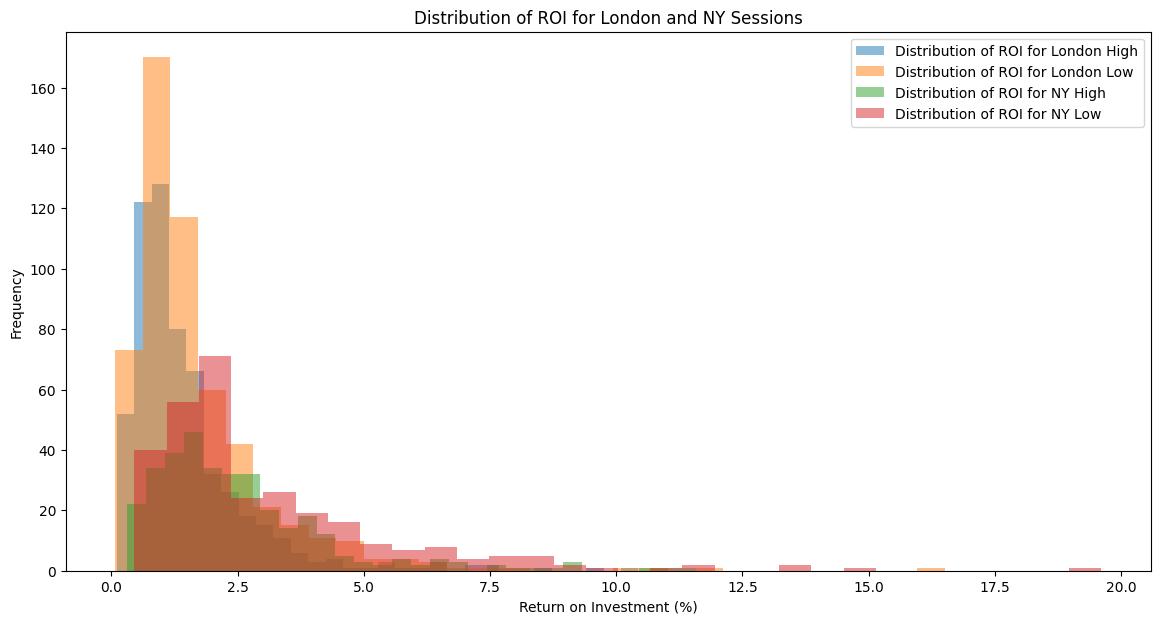

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.hist(aggregated_df['percent_move_from_london_high'].dropna().astype(float), bins=30, alpha=0.5, label='Distribution of ROI for London High')
plt.hist(aggregated_df['percent_move_from_london_low'].dropna().astype(float), bins=30, alpha=0.5, label='Distribution of ROI for London Low')
plt.hist(aggregated_df['percent_both_london_ny_exceed_high'].dropna().astype(float), bins=30, alpha=0.5, label='Distribution of ROI for NY High')
plt.hist(aggregated_df['percent_both_london_ny_exceed_low'].dropna().astype(float), bins=30, alpha=0.5, label='Distribution of ROI for NY Low')
plt.xlabel('Return on Investment (%)')
plt.ylabel('Frequency')
plt.title('Distribution of ROI for London and NY Sessions')
plt.legend()
plt.show()

In [53]:
# Convert 'date' column to datetime format
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

# Filter for the year 2020
df_2020 = aggregated_df[aggregated_df['date'].dt.year == 2020]

# Calculate the sum of 'percent_move_from_london_high'
sum_percent_move_high = df_2020['percent_move_from_london_high'].sum()
sum_percent_move_low = df_2020['percent_move_from_london_low'].sum()
sum_of_sum = sum_percent_move_high + sum_percent_move_low
average_percent_move_high = df_2020['percent_move_from_london_high'].mean()
average_percent_move_low = df_2020['percent_move_from_london_low'].mean()
avg_of_avg = (average_percent_move_high + average_percent_move_low) / 2

print(f"Total ROI for London High: {round(sum_percent_move_high, 2)}%")
print(f"Total ROI for London Low: {round(sum_percent_move_low, 2)}%")
print(f"Average ROI for London High: {round(average_percent_move_high, 2)}%")
print(f"Average ROI for London Low: {round(average_percent_move_low, 2)}%")
print(f"Total ROI for London High and Low: {round(sum_of_sum, 2)}%")
print(f"Average ROI for London High and Low: {round(avg_of_avg, 2)}%")

Total ROI for London High: 222.68%
Total ROI for London Low: 271.69%
Average ROI for London High: 1.78%
Average ROI for London Low: 1.94%
Total ROI for London High and Low: 494.37%
Average ROI for London High and Low: 1.86%


In [54]:
# Convert 'date' column to datetime format
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

# Filter for the year 2020
df_2020 = aggregated_df[aggregated_df['date'].dt.year == 2021]

# Calculate the sum of 'percent_move_from_london_high'
sum_percent_move_high = df_2020['percent_move_from_london_high'].sum()
sum_percent_move_low = df_2020['percent_move_from_london_low'].sum()
sum_of_sum = sum_percent_move_high + sum_percent_move_low
average_percent_move_high = df_2020['percent_move_from_london_high'].mean()
average_percent_move_low = df_2020['percent_move_from_london_low'].mean()
avg_of_avg = (average_percent_move_high + average_percent_move_low) / 2

print(f"Total ROI for London High: {round(sum_percent_move_high, 2)}%")
print(f"Total ROI for London Low: {round(sum_percent_move_low, 2)}%")
print(f"Average ROI for London High: {round(average_percent_move_high, 2)}%")
print(f"Average ROI for London Low: {round(average_percent_move_low, 2)}%")
print(f"Total ROI for London High and Low: {round(sum_of_sum, 2)}%")
print(f"Average ROI for London High and Low: {round(avg_of_avg, 2)}%")

Total ROI for London High: 249.47%
Total ROI for London Low: 316.29%
Average ROI for London High: 1.77%
Average ROI for London Low: 2.49%
Total ROI for London High and Low: 565.76%
Average ROI for London High and Low: 2.13%


In [55]:
# Convert 'date' column to datetime format
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

# Filter for the year 2020
df_2020 = aggregated_df[aggregated_df['date'].dt.year == 2022]

# Calculate the sum of 'percent_move_from_london_high'
sum_percent_move_high = df_2020['percent_move_from_london_high'].sum()
sum_percent_move_low = df_2020['percent_move_from_london_low'].sum()
sum_of_sum = sum_percent_move_high + sum_percent_move_low
average_percent_move_high = df_2020['percent_move_from_london_high'].mean()
average_percent_move_low = df_2020['percent_move_from_london_low'].mean()
avg_of_avg = (average_percent_move_high + average_percent_move_low) / 2

print(f"Total ROI for London High: {round(sum_percent_move_high, 2)}%")
print(f"Total ROI for London Low: {round(sum_percent_move_low, 2)}%")
print(f"Average ROI for London High: {round(average_percent_move_high, 2)}%")
print(f"Average ROI for London Low: {round(average_percent_move_low, 2)}%")
print(f"Total ROI for London High and Low: {round(sum_of_sum, 2)}%")
print(f"Average ROI for London High and Low: {round(avg_of_avg, 2)}%")

Total ROI for London High: 175.94%
Total ROI for London Low: 165.37%
Average ROI for London High: 1.47%
Average ROI for London Low: 1.46%
Total ROI for London High and Low: 341.31%
Average ROI for London High and Low: 1.46%


In [56]:
# Convert 'date' column to datetime format
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

# Filter for the year 2020
df_2020 = aggregated_df[aggregated_df['date'].dt.year == 2023]

# Calculate the sum of 'percent_move_from_london_high'
sum_percent_move_high = df_2020['percent_move_from_london_high'].sum()
sum_percent_move_low = df_2020['percent_move_from_london_low'].sum()
sum_of_sum = sum_percent_move_high + sum_percent_move_low
average_percent_move_high = df_2020['percent_move_from_london_high'].mean()
average_percent_move_low = df_2020['percent_move_from_london_low'].mean()
avg_of_avg = (average_percent_move_high + average_percent_move_low) / 2

print(f"Total ROI for London High: {round(sum_percent_move_high, 2)}%")
print(f"Total ROI for London Low: {round(sum_percent_move_low, 2)}%")
print(f"Average ROI for London High: {round(average_percent_move_high, 2)}%")
print(f"Average ROI for London Low: {round(average_percent_move_low, 2)}%")
print(f"Total ROI for London High and Low: {round(sum_of_sum, 2)}%")
print(f"Average ROI for London High and Low: {round(avg_of_avg, 2)}%")

Total ROI for London High: 116.83%
Total ROI for London Low: 104.84%
Average ROI for London High: 0.93%
Average ROI for London Low: 0.99%
Total ROI for London High and Low: 221.67%
Average ROI for London High and Low: 0.96%


In [57]:
# Convert 'date' column to datetime format
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])

# Filter for the year 2020
df_2020 = aggregated_df[aggregated_df['date'].dt.year == 2024]

# Calculate the sum of 'percent_move_from_london_high'
sum_percent_move_high = df_2020['percent_move_from_london_high'].sum()
sum_percent_move_low = df_2020['percent_move_from_london_low'].sum()
sum_of_sum = sum_percent_move_high + sum_percent_move_low
average_percent_move_high = df_2020['percent_move_from_london_high'].mean()
average_percent_move_low = df_2020['percent_move_from_london_low'].mean()
avg_of_avg = (average_percent_move_high + average_percent_move_low) / 2

print(f"Total ROI for London High: {round(sum_percent_move_high, 2)}%")
print(f"Total ROI for London Low: {round(sum_percent_move_low, 2)}%")
print(f"Average ROI for London High: {round(average_percent_move_high, 2)}%")
print(f"Average ROI for London Low: {round(average_percent_move_low, 2)}%")
print(f"Total ROI for London High and Low: {round(sum_of_sum, 2)}%")
print(f"Average ROI for London High and Low: {round(avg_of_avg, 2)}%")

Total ROI for London High: 87.03%
Total ROI for London Low: 64.73%
Average ROI for London High: 1.26%
Average ROI for London Low: 1.27%
Total ROI for London High and Low: 151.76%
Average ROI for London High and Low: 1.27%


In [58]:
high = aggregated_df.percent_move_from_london_high.mean()
low = aggregated_df.percent_move_from_london_low.mean()
both = (high + low) / 2
print(f"Average ROI for London High: {round(high, 2)}%")

Average ROI for London High: 1.47%
